# 1. Introduction

#### Problem Statement

#### Motivation

#### Approach

#### Libraries

### Install Libraries

In [14]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [15]:
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!python -m textblob.download_corpora

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 2.9/12.8 MB 16.8 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 17.5 MB/s eta 0:00:01
     ------------------------------- ------- 10.2/12.8 MB 17.2 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 17.1 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 17.1 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 11.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     -- ------------------------------------- 1.8/33.5 MB 14.4 MB/s eta 0:00:03
     ------ --------------------------------- 5.8/33.5 MB 16.8 MB/s eta 0:00:02
     ----------- ---------------------------- 9.4/33.5 MB 16.8 MB/s eta 0:00:02
     -------------- -------------

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_

In [16]:
cd C:\Users\Zaid.Qarout\Toxic Comment Classification Challenge"

C:\Users\Zaid.Qarout\Toxic Comment Classification Challenge


## Importing Libraries and Defining Variables

In [17]:
import warnings, numpy as np
import pandas as pd
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import scipy.sparse
# import nltk

# nltk.download('stopwords')

from collections import Counter
from spacy import displacy
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud

# from nltk.corpus import stopwords

# 2. Load Data

In [18]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

#### Observe the first 5 rows of each data set

In [19]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


#### Check the shape of the datasets

In [21]:
print('Train shape', df_train.shape)
print('Test shape', df_test.shape)

Train shape (159571, 8)
Test shape (153164, 2)


#### Check the column names

In [22]:
df_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

#### Check for missing data

In [23]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### View label distribution
Sort values to see the most common labels first

In [24]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train[labels].sum().sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

# 3. Preprocessing and Data Cleaning

### Variables

In [25]:
# fast, vector-ready model (has 300-d GloVe vectors)
nlp = spacy.load("en_core_web_md", disable=["ner", "parser", "tagger"]) # Load the spaCy model with only the tokeniser

if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

### Clean the data

In [26]:
def clean(text):
    """Function to clean the text data using spaCy.
    Args:
        doc (str): The text to be cleaned.
    Returns: the cleaned text as a string."""
    PUNCTUATION_TABLE = str.maketrans("", "", string.punctuation.replace("'", ""))  # Remove punctuation except apostrophes
    return text.lower().translate(PUNCTUATION_TABLE).replace('\n', ' ').replace('\r', ' ').strip()

### Tokenise the data

In [38]:
# Define regex patterns for token filtering
url_pattern = re.compile(r'https?://\S+|www\.\S+')
email_pattern = re.compile(r'\b[\w\.-]+?@\w+?\.\w+?\b')
repetition_pattern = re.compile(r'(.)\1{3,}')  # e.g., 'aaaa', 'bbbb'
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE
)


def tokenise(text):
    """Function to tokenise the text data using spaCy.
    Args:
        text (str): The text to be tokenised.
    Returns: a list of tokens (lemmas) as strings."""
    doc = nlp(text)
    # Tokenise the document using spaCy
    tokens = [
    token.lemma_.lower()
    for token in doc
    if (
        not token.is_stop and  # Exclude stop words
        not token.is_punct and  # Exclude punctuation
        not token.is_space and  # Exclude spaces
        len(token.text.strip()) > 1 and # Exclude single-character tokens (e.g., 'a', 'I' etc. except for contractions like "don't", "can't" etc. which are handled by the tokenisation process)
        not url_pattern.match(token.text) and # Exclude tokens that match the URL pattern
        not email_pattern.match(token.text) and  # Exclude tokens that match the email pattern (e.g., '
        not repetition_pattern.match(token.text) and # Exclude tokens that match the repetition pattern (e.g., 'aaaa', 'bbbb' etc.)
        not emoji_pattern.match(token.text) and # Exclude tokens that match the emoji pattern (e.g., '😊', '😂' etc.)
        not re.match(r'^\d+$', token.text) # Exclude tokens that are purely numeric (e.g., '123', '4567' etc. but keep numbers in words like "one", "two" etc. which are handled by the tokenisation process)
    )
]

    return tokens

### Sentence count

In [31]:
def sentence_count(doc):
    """ Function to count the number of sentences in the text data.
    Args:
        doc (spacy.tokens.Doc): The processed text document.
    Returns: the number of sentences."""
    return len(list(doc.sents))  # Count the number of sentences in the document

### Get sentiment scores

In [32]:
def get_sentiment_scores(text):
    """
    Function to get the sentiment scores of the text data.
    Args:
        text (str): The text to be processed.
    Returns: a dictionary with polarity and subjectivity scores."""
    blob = TextBlob(text)  # Create a TextBlob object
    return {'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity}  # Return the sentiment scores as a dictionary

# 4. Linguistic Feature Extraction

### Part-of-speech tagging (POS)
Show the grammatical role of each word (eg. noun, verb...)

In [33]:
def print_pos_tags(doc):
    """ Function to print the part-of-speech (POS) tags of the text data.
    Args:
        doc (spacy.tokens.Doc): The processed text document.
    Returns: None, but prints the POS tags."""
    # Print each token and its POS tag
    for token in doc:
        print(f"{token.text} - {token.pos_}")  # Print each token and its POS tag

### Name entity recognition (NER)
Finds named entities like countries, people, dates...

In [34]:
def print_ner(doc):
    """ Function to print named entities in the text data.
    Args:
        doc (spacy.tokens.Doc): The processed text document.
    Returns: None, but prints the named entities."""
    for ent in doc.ents:
        print(f"{ent.text} - {ent.label_}")  # Print each entity and its label

### Dependency parsing
Shows how each word depends on another in the sentence

In [35]:
def print_dependency_parse(doc):
    """ Function to print the dependency parse of the text data.
    Args:
        doc (spacy.tokens.Doc): The processed text document.
    Returns: None, but prints the dependency parse."""
    for token in doc:
        print(f"{token.text} - {token.dep_} - {token.head.text}")  # Print each token, its dependency relation, and its head

### Sentiment counts


### Sentiment scores

# 5. Feature engineering

In [36]:
def extract_features(text):
    """ Function to extract features from the text data.
    Args:
        text (str): The text to be processed.
    Returns: a dictionary with various features extracted from the text."""
    
    if not isinstance(text, str) or not text.strip():
        # Return default values if input is not valid
        return {
            'cleaned_text': '',
            'tokens': [],
            'sentence_count': 0,
            'pos_tags': [],
            'ner': [],
            'dependency_parse': [],
            'sentiment_scores': {'polarity': 0.0, 'subjectivity': 0.0}
        }

    
    doc = nlp(text)  # Process the text with spaCy
    return {
        'cleaned_text': clean(text),  # Cleaned text
        'tokens': tokenise(doc),  # Tokenised text
        'sentence_count': sentence_count(doc),  # Number of sentences
        'pos_tags': [(token.text, token.pos_) for token in doc],  # POS tags
        'ner': [(ent.text, ent.label_) for ent in doc.ents],  # Named entities
        'dependency_parse': [(token.text, token.dep_, token.head.text) for token in doc],  # Dependency parse
        'sentiment_scores': get_sentiment_scores(text)  # Sentiment scores
    }


### Apply data cleaning methods

In [39]:
# ============ DEVELOPMENT MODE =========== #
# (a small sample to save time)

df_small = df_train.sample(n=5000, random_state=42)
features = df_small['comment_text'].apply(extract_features)
features_df = pd.json_normalize(features, sep='_')

df_small = df_small.reset_index(drop=True)
features_df = features_df.reset_index(drop=True)

df = pd.concat([df_small, features_df], axis=1)
# ========================================= #

# ============ FULL DATASET MODE (SUBMISSION) =========== #
# Uncomment this just before training and submission

# features = df_train['comment_text'].apply(extract_features)
# features_df = pd.json_normalize(features, sep='_')

# Align indices before combining

# df_train = df_train.reset_index(drop=True)
# features_df = features_df.reset_index(drop=True)

# Final working DataFrame for exploration

# df = pd.concat([df_train, features_df], axis=1)
# ======================================================== #


C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,tokens,sentence_count,pos_tags,ner,dependency_parse,sentiment_scores_polarity,sentiment_scores_subjectivity
0,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0,geez are you forgetful we've already discusse...,"[geez, forgetful, discussed, marx, anarchist, ...",5,"[(Geez, ), (,, ), (are, ), (you, ), (forgetful...",[],"[(Geez, , Geez), (,, , ,), (are, , are), (you,...",-8.333333e-03,0.200000
1,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0,carioca rfa thanks for your support on my re...,"[carioca, rfa, thanks, support, request, admin...",4,"[(Carioca, ), (RFA, ), (\n\n, SPACE), (Thanks,...",[],"[(Carioca, , Carioca), (RFA, , RFA), (\n\n, , ...",1.000000e-01,0.600000
2,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0,birthday no worries it's what i do enjoy ur ...,"[birthday, worries, enjoy, ur, day|talk|e]",1,"[("", ), (\n\n , SPACE), (Birthday, ), (\n\n, S...",[],"[("", , ""), (\n\n , , \n\n ), (Birthday, , Birt...",3.250000e-01,0.750000
3,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0,pseudoscience category i'm assuming that thi...,"[pseudoscience, category, assuming, article, p...",4,"[(Pseudoscience, ), (category, ), (?, ), (\n\n...",[],"[(Pseudoscience, , Pseudoscience), (category, ...",1.266667e-01,0.398333
4,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0,and if such phrase exists it would be provided...,"[phrase, exists, provided, search, engine, men...",1,"[((, ), (and, ), (if, ), (such, ), (phrase, ),...",[],"[((, , (), (and, , and), (if, , if), (such, , ...",0.000000e+00,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ba6f9b741648e4e4,"""\n\nIn response to Bduke's question 2 above, ...",0,0,0,0,0,0,in response to bduke's question 2 above i thin...,"[response, bduke, question, 2, think, difficul...",9,"[("", ), (\n\n, SPACE), (In, ), (response, ), (...",[],"[("", , ""), (\n\n, , \n\n), (In, , In), (respon...",-3.965082e-18,0.571429
4996,5c827588ebf39fe6,"""\nSupport as above Slash """,0,0,0,0,0,0,support as above slash,"[support, slash]",1,"[("", ), (\n, SPACE), (Support, ), (as, ), (abo...",[],"[("", , ""), (\n, , \n), (Support, , Support), (...",0.000000e+00,0.100000
4997,e52f35b373fa6bbb,REDIRECT Talk:Magar class amphibious warfare v...,0,0,0,0,0,0,redirect talkmagar class amphibious warfare ve...,"[redirect, talk, magar, class, amphibious, war...",1,"[(REDIRECT, ), (Talk, ), (:, ), (Magar, ), (cl...",[],"[(REDIRECT, , REDIRECT), (Talk, , Talk), (:, ,...",0.000000e+00,0.000000
4998,7b681dbd3aa67ef6,"""\n\nSanger & Sangists\nI've added the """""""" te...",0,0,0,0,0,0,sanger sangists i've added the template to t...,"[sanger, sangists, added, template, article, s...",5,"[("", ), (\n\n, SPACE), (Sanger, ), (&, ), (San...",[],"[("", , ""), (\n\n, , \n\n), (Sanger, , Sanger),...",2.666667e-01,0.550000


# 6. Exploratory data analysis (EDA)

In [40]:
eda_rows, top_words = [], {}
for lab in labels:
    sub = df_tSo my jurain[df_train[lab]==1]
    n_comments = len(sub)
    n_sentences = sub["comment_text"].str.count(r"[.!?]").sum()
    all_tokens = np.concatenate(sub["comment_text"].apply(tokenise).values)
    n_tokens = len(all_tokens)
    top_words[lab] = [w for w,_ in Counter(all_tokens).most_common(20)]
    eda_rows.append((lab, n_comments, n_sentences, n_tokens))

eda_df = pd.DataFrame(eda_rows, columns=["label","comments","sentences","tokens"])
display(eda_df)
pd.DataFrame(top_words).T.style.set_caption("Top-20 tokens per class")

C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that

,label,comments,sentences,tokens
0,toxic,15294,120035,381131
1,severe_toxic,1595,33133,69767
2,obscene,8449,62418,208938
3,threat,478,10384,12783
4,insult,7877,59246,189140
5,identity_hate,1405,8410,41583


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
toxic,fuck,shit,like,wikipedia,nigger,fucking,suck,ass,hate,gay,know,page,die,fat,faggot,people,moron,hi,cunt,sucks
severe_toxic,fuck,suck,shit,ass,faggot,fucking,die,nigger,sucks,cunt,bitch,wikipedia,cock,fucksex,yourselfgo,fucker,kill,dick,cocksucker,piece
obscene,fuck,shit,fucking,suck,nigger,ass,wikipedia,like,cunt,bitch,fat,know,die,dick,faggot,bullshit,page,sucks,asshole,stupid
threat,die,ass,kill,going,block,jim,wales,supertr0ll,fucking,fuck,ban,page,wikipedia,talk,murder,live,fuckin,rvv,blank,di
insult,fuck,nigger,fucking,suck,ass,fat,faggot,shit,like,moron,cunt,hi,hate,bitch,jew,wikipedia,die,know,stupid,dick
identity_hate,nigger,fat,jew,gay,die,fuck,faggot,fucking,huge,suck,shit,stupid,cunt,like,ass,mexicans,bitch,niggas,hate,bunksteve


## Word Clouds per toxicity class

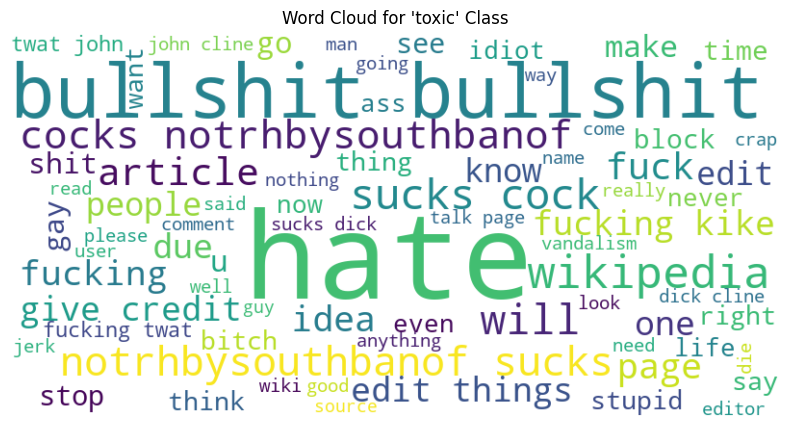

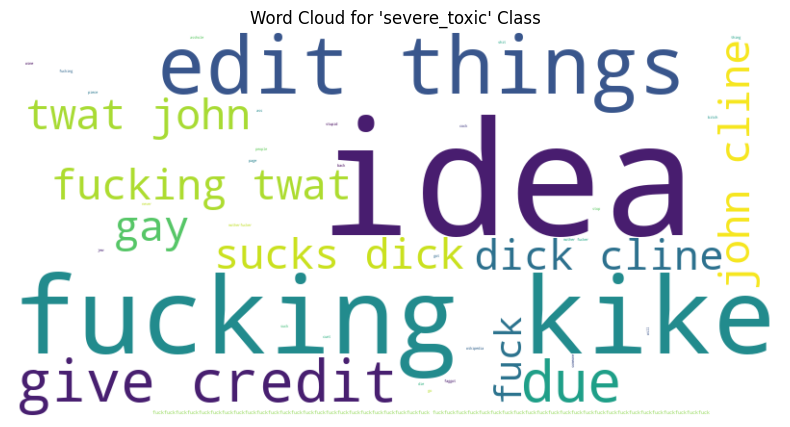

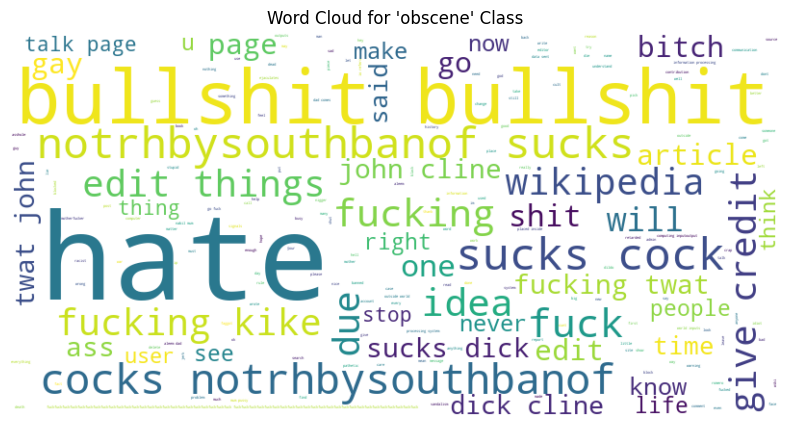

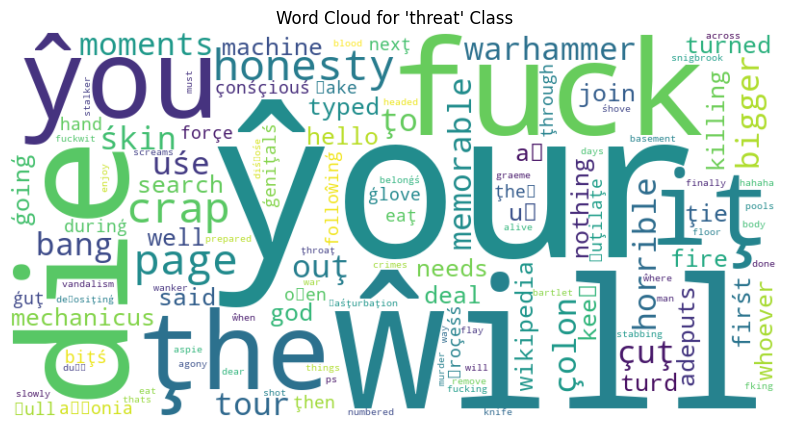

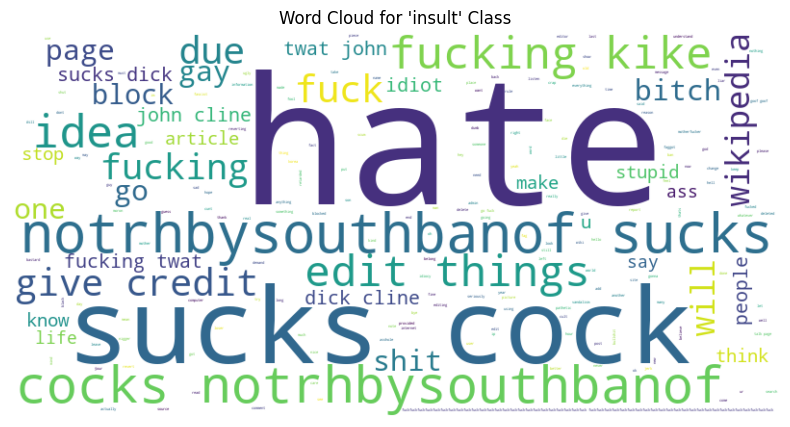

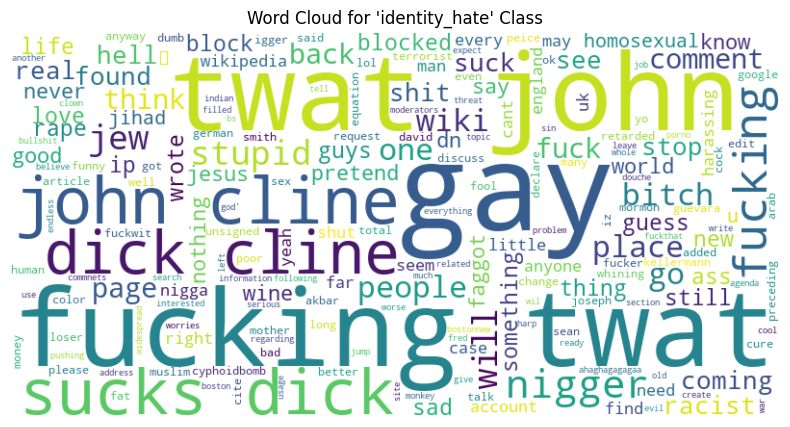

In [41]:
for label in labels:
    text = " ".join(df[df[label] == 1]['cleaned_text'].dropna())
    
    if not text.strip():
        continue  # Skip empty classes
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{label}' Class")
    plt.show()

# 7. Text vectorisation (TF-IDF and WordEmbeddings)

### TF-IDF (Term Frequency - Inverse Document Frequency)

In [42]:
# X is input features and y is the output labels

df = df.dropna(subset=['cleaned_text'])
X = df['cleaned_text']  # Features: cleaned text
y = df[labels]  # Target labels

X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)  # Split the data into training and validation sets

tfidf_vec = TfidfVectorizer(
    tokenizer=tokenise, # Tokeniser function to convert text to tokens
    preprocessor=clean,  # Preprocessor function to clean the text
    lowercase=False, # Skip internal lower-casing
    min_df=2, # Minimum document frequency to ignore rare words
    max_features=30_000, # Maximum number of features to consider
    ngram_range=(1,2) # Vectoriser to convert text to TF-IDF features
)  # Vectoriser to convert text to TF-IDF features
# Note: tokenizer is a function that takes a string and returns a list of tokens

X_tfidf_train = tfidf_vec.fit_transform(X_train_tfidf)
X_tfidf_val  = tfidf_vec.transform(X_val_tfidf)

# Save the TF-IDF matrices and vectoriser for later use
scipy.sparse.save_npz("X_tfidf_train.npz", X_tfidf_train) # Save the training TF-IDF matrix
scipy.sparse.save_npz("X_tfidf_val.npz", X_tfidf_val) # Save the validation TF-IDF matrix
joblib.dump(tfidf_vec, "tfidf_vectorizer.pkl") # Save the TF-IDF vectoriser

C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Zaid.Qarout\AppData\Local\miniconda3\envs\jupyter-env\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


['tfidf_vectorizer.pkl']

### Word Embeddings

In [43]:
X_text_embed = df_train['comment_text'].apply(lambda x: nlp(x).vector) # Convert the text to word embeddings using spaCy
# Note: This will create a 300-dimensional dense vector for each comment
y_embed = df_train[labels] # Extract the labels for word embeddings

X_train_embed, X_val_embed, y_train_embed, y_val_embed = train_test_split(
    X_text_embed, y_embed, test_size=0.2, random_state=42
) # Split the data into training and validation sets

# Function to convert text to a dense vector using spaCy
def doc_vector(text):
    doc = nlp(text)
    return doc.vector # 300-d dense vector

X_embed_train = np.vstack(X_train_embed.values) # Convert the training text embeddings to a 2D array
X_embed_val = np.vstack(X_val_embed.values) # Convert the validation text embeddings to a 2D array

# Save the word embeddings for later use
np.save("X_embed_train.npy", X_embed_train)
np.save("X_embed_val.npy", X_embed_val)

# 8. Model training and evaluation

In [44]:
# ALGOS = {
#     "LogReg" : LogisticRegression(max_iter=1000, class_weight="balanced"),
#     "LinearSVM": LinearSVC(class_weight="balanced"),
#     "MultNB" : MultinomialNB()
# }

## Logistic regression

In [47]:
# For TF-IDF
model_tfidf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
model_tfidf.fit(X_tfidf_train, y_train)
y_pred_tfidf = model_tfidf.predict(X_tfidf_val)

print("TF-IDF + Logistic Regression")
print(classification_report(y_val, y_pred_tfidf, target_names=labels, zero_division=0))

# For Word Embeddings
model_embed = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
model_embed.fit(X_embed_train, y_train_embed)
y_pred_embed = model_embed.predict(X_embed_val)

print("Word Embedding + Logistic Regression")
print(classification_report(y_val_embed, y_pred_embed, target_names=labels, zero_division=0))

TF-IDF + Logistic Regression
               precision    recall  f1-score   support

        toxic       0.67      0.66      0.67        91
 severe_toxic       0.07      0.17      0.10         6
      obscene       0.90      0.66      0.76        53
       threat       0.00      0.00      0.00         3
       insult       0.67      0.66      0.67        44
identity_hate       0.29      0.33      0.31        12

    micro avg       0.65      0.62      0.63       209
    macro avg       0.43      0.41      0.42       209
 weighted avg       0.68      0.62      0.64       209
  samples avg       0.05      0.05      0.05       209

Word Embedding + Logistic Regression
               precision    recall  f1-score   support

        toxic       0.44      0.82      0.57      3056
 severe_toxic       0.14      0.90      0.24       321
      obscene       0.38      0.84      0.52      1715
       threat       0.03      0.89      0.06        74
       insult       0.36      0.86      0.50      

## Multi-LayerPerceptron

In [ ]:
# For TF-IDF
model_mlp_tfidf = OneVsRestClassifier(
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
)
model_mlp_tfidf.fit(X_tfidf_train, y_train)
y_pred_mlp_tfidf = model_mlp_tfidf.predict(X_tfidf_val)

print("TF-IDF + MLP")
print(classification_report(y_val, y_pred_mlp_tfidf, target_names=labels, zero_division=0))

# For Word Embeddings
model_mlp_embed = OneVsRestClassifier(
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
)
model_mlp_embed.fit(X_embed_train, y_train_embed)
y_pred_mlp_embed = model_mlp_embed.predict(X_embed_val)

print("Word Embedding + MLP")
print(classification_report(y_val_embed, y_pred_mlp_embed, target_names=labels, zero_division=0))

## KNN

In [ ]:
# For TF-IDF
model_knn_tfidf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5, metric='cosine'))
model_knn_tfidf.fit(X_tfidf_train, y_train)
y_pred_knn_tfidf = model_knn_tfidf.predict(X_tfidf_val)

print("TF-IDF + KNN")
print(classification_report(y_val, y_pred_knn_tfidf, target_names=labels, zero_division=0))

# For Word Embeddings
model_knn_embed = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5, metric='cosine'))
model_knn_embed.fit(X_embed_train, y_train_embed)
y_pred_knn_embed = model_knn_embed.predict(X_embed_val)

print("Word Embedding + KNN")
print(classification_report(y_val_embed, y_pred_knn_embed, target_names=labels, zero_division=0))

TF-IDF + KNN
               precision    recall  f1-score   support

        toxic       0.74      0.49      0.59        91
 severe_toxic       0.00      0.00      0.00         6
      obscene       0.87      0.49      0.63        53
       threat       0.00      0.00      0.00         3
       insult       0.69      0.41      0.51        44
identity_hate       0.00      0.00      0.00        12

    micro avg       0.72      0.43      0.54       209
    macro avg       0.38      0.23      0.29       209
 weighted avg       0.69      0.43      0.52       209
  samples avg       0.04      0.03      0.04       209

Word Embedding + KNN
               precision    recall  f1-score   support

        toxic       0.67      0.48      0.56      3056
 severe_toxic       0.39      0.26      0.31       321
      obscene       0.67      0.49      0.57      1715
       threat       0.45      0.12      0.19        74
       insult       0.62      0.44      0.52      1614
identity_hate       0.40   

# 9. Results visualisation

In [ ]:

def evaluate_auc(y_true, y_scores, model_name, labels):
    """ Function to evaluate AUC scores for each class and print the results.
    Args:
        y_true (np.ndarray): True labels in a binary format (shape: [n_samples, n_classes]).
        y_scores (np.ndarray): Predicted scores or probabilities (shape: [n_samples, n_classes]).
        model_name (str): Name of the model being evaluated.
        labels (list): List of class labels.
    Returns:
        auc_per_class (dict): A dictionary with AUC scores for each class.
        macro_auc (float): Macro-average AUC score.
        micro_auc (float): Micro-average AUC score.
    """
    
    # Compute AUC per class
    auc_per_class = {}
    for i, label in enumerate(labels):
        try:
            auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        except ValueError:
            auc = 0.0  # If only one class present in y_true
        auc_per_class[label] = auc

    # Print AUC scores
    print(f"AUC Scores for: {model_name}")
    for label, auc in auc_per_class.items():
        print(f"  {label:<15}: {auc:.3f}")

    # Compute and print macro and micro averages
    macro_auc = roc_auc_score(y_true, y_scores, average='macro')
    micro_auc = roc_auc_score(y_true, y_scores, average='micro')

    print(f"\nMacro AUC: {macro_auc:.3f}")
    print(f"Micro AUC: {micro_auc:.3f}")
    
    return auc_per_class, macro_auc, micro_auc

In [ ]:
# Ensure you have probability outputs
y_scores_tfidf = model_tfidf.predict_proba(X_tfidf_val)
y_val_array = y_val.values  # Convert to NumPy array if it's a DataFrame

# Evaluate
evaluate_auc(y_val_array, y_scores_tfidf, "TF-IDF + Logistic Regression", labels)

NameError: name 'model_tfidf' is not defined

In [ ]:
model_embed = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
model_embed.fit(X_embed_train, y_train_embed)
y_pred_embed = model_embed.predict(X_embed_val)

KeyboardInterrupt: 

In [ ]:
# Assuming model_embed_mlp is trained
y_scores_embed = model_mlp_embed.predict_proba(X_embed_val)
y_val_embed_array = y_val_embed.values # Convert to NumPy array if it's a DataFrame

evaluate_auc(y_val_embed_array, y_scores_embed, "Word Embedding + MLP", labels)

📊 AUC Scores for: Word Embedding + MLP
  toxic          : 0.915
  severe_toxic   : 0.959
  obscene        : 0.935
  threat         : 0.938
  insult         : 0.939
  identity_hate  : 0.922

Macro AUC: 0.935
Micro AUC: 0.950


({'toxic': 0.9146341362472059,
  'severe_toxic': 0.9594673423736554,
  'obscene': 0.9350311142432376,
  'threat': 0.937704404571023,
  'insult': 0.9391071683215415,
  'identity_hate': 0.9218693359510719},
 0.9346355836179558,
 0.9502655512378966)

In [ ]:
# Evaluate KNN models
y_scores_knn_tfidf = model_knn_tfidf.predict_proba(X_tfidf_val)
evaluate_auc(y_val_array, y_scores_knn_tfidf, "TF-IDF + KNN", labels)
y_scores_knn_embed = model_knn_embed.predict_proba(X_embed_val) 

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Visualisation helpers
def bar_true_vs_pred(y_true: pd.DataFrame,
                     y_pred: np.ndarray,
                     labels: list,
                     title_suffix: str = ""):
    """
    Side-by-side bar chart of true vs. predicted counts for each label.
    Works for multilabel problems (y_true is a DataFrame of 0/1 columns).
    """
    true_counts = y_true.values.sum(axis=0)
    pred_counts = y_pred.sum(axis=0)

    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x - .2, true_counts,  width=.4, label="True", color="steelblue")
    plt.bar(x + .2, pred_counts, width=.4, label="Pred", color="tomato")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Samples")
    plt.title(f"True vs. Predicted counts {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def per_label_confusion_matrices(y_true: pd.DataFrame,
                                 y_pred: np.ndarray,
                                 labels: list,
                                 cmap="YlOrRd"):
    """
    For each label produce a 2×2 confusion-matrix heat-map.
    """
    n = len(labels)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 4*nrows),
                             squeeze=False)
    for idx, lab in enumerate(labels):
        r, c = divmod(idx, ncols)
        cm = confusion_matrix(y_true[lab], y_pred[:, idx])
        sns.heatmap(cm,
                    annot=True, fmt="d",
                    cbar=False, cmap=cmap,
                    ax=axes[r, c])
        axes[r, c].set_title(lab)
        axes[r, c].set_xlabel("Predicted")
        axes[r, c].set_ylabel("True")
    # turn off empty plots
    for j in range(idx+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")
    plt.tight_layout()
    plt.show()


def per_label_roc_curves(y_true: pd.DataFrame,
                         y_prob: np.ndarray,
                         labels: list):
    """
    Draw ROC curve for every label (works if you have probability scores).
    """
    plt.figure(figsize=(6, 6))
    for i, lab in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_true[lab], y_prob[:, i])
        auc  = roc_auc_score(y_true[lab], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{lab} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="grey")
    plt.xlabel("False-positive rate")
    plt.ylabel("True-positive rate")
    plt.title("ROC curves (per label)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def classification_table(y_true: pd.DataFrame,
                         y_pred: np.ndarray,
                         labels: list):
    """
    Nicely formatted per-label precision / recall / F1.
    Suppresses KeyError if a summary row is missing.
    """
    report = classification_report(y_true.values,
                                   y_pred,
                                   target_names=labels,
                                   output_dict=True,
                                   zero_division=0)
    df = (pd.DataFrame(report).T
            .drop(["accuracy", "macro avg", "weighted avg",
                   "micro avg", "samples avg"],
                  errors="ignore"))            # <-- key change
    display(df.style.format("{:.3f}")
                  .background_gradient(cmap="Blues"))
    return df


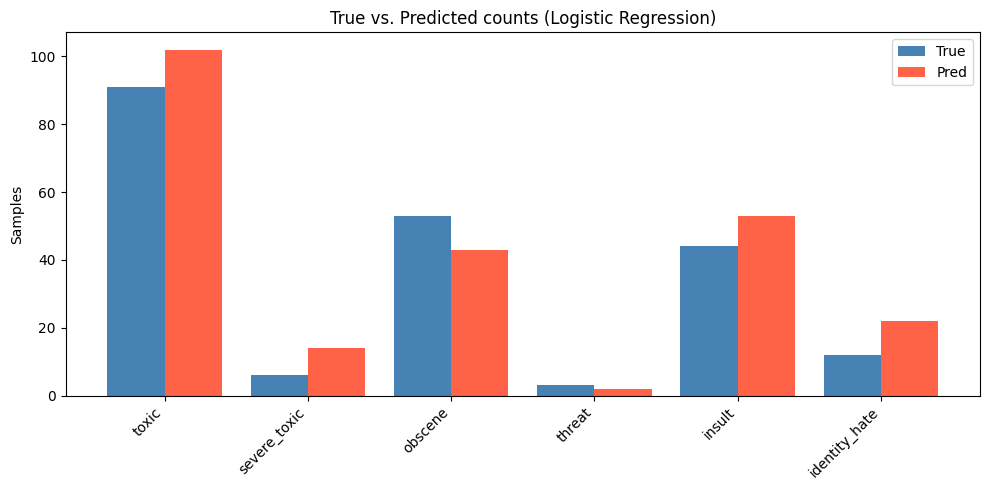

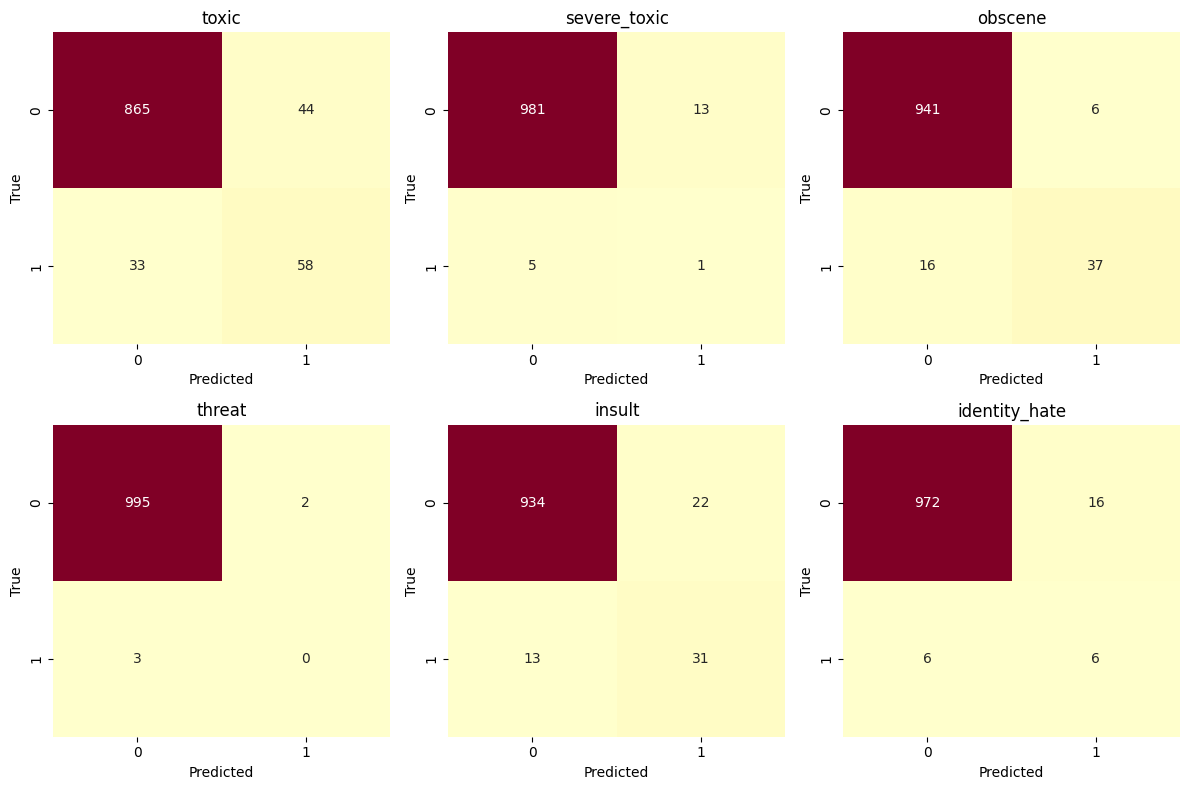

,precision,recall,f1-score,support
toxic,0.569,0.637,0.601,91.000
severe_toxic,0.071,0.167,0.100,6.000
obscene,0.860,0.698,0.771,53.000
threat,0.000,0.000,0.000,3.000
insult,0.585,0.705,0.639,44.000
identity_hate,0.273,0.500,0.353,12.000


,precision,recall,f1-score,support
toxic,0.568627,0.637363,0.601036,91.0
severe_toxic,0.071429,0.166667,0.100000,6.0
obscene,0.860465,0.698113,0.770833,53.0
threat,0.000000,0.000000,0.000000,3.0
insult,0.584906,0.704545,0.639175,44.0
identity_hate,0.272727,0.500000,0.352941,12.0


In [ ]:
# y_test_lg  : DataFrame of ground truth  (shape = [n_samples, 6])
# y_pred_lg  : binary numpy array from model.predict(...)
# y_prob_lg  : probability/decision scores (optional, for ROC curves)

bar_true_vs_pred(y_test_lg, y_pred_lg, labels,
                 title_suffix="(Logistic Regression)")

per_label_confusion_matrices(y_test_lg, y_pred_lg, labels)

classification_table(y_test_lg, y_pred_lg, labels)

### Helper to train & collect metrics (reuse your visual-helpers later)

###  Train all 3 models on word-TF-IDF

### Train the same 3 models on char-TF-IDF

### Compare everything

### Visualise the best combo

### Kaggle submission